# Vignette on Anomaly Detection

by Ivan Li, Justin Lang, Keon Dibley, Sanchit Mehtora

## Introduction

Anomaly detection is a powerful way to separate normal data from outliers. Additionally, it can help data scientists find those specific anomalies and inquire more about them: if they are errors in data collection or concerning values that require more attention. In this vignette, we will delve into different ways to find the anomaly values with data sets concerning climate and data network.



# Climate Data Time Series

## Dataset Description

The dataset that we used for climate data time series analysis came from kaggle at this [link]{https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download}

It measured daily climate data in Delhi from 2013 to 2017 in the form of
 - mean temperature,
 - humidity,
 - speed
 - mean pressure



##  Methods

In the climate time series, we utilized sckit-learn's isolation forest in order to determine anomaly detection.

Isolation Forest in particular has four important hyperparameters that can be assigned.

    - n_estimators
        - # of trees in the Forest
    - max_samples
        - Samples per tree to train
    - contamination
        - How much of population do you think are anomalies
    - max_features
        - How many features used to train each tree


##  How Islation Forest Works

Anomalies exist because their feature values differ greatly from other regular values in the dataset. How an isolation forest works is that it creates trees and splits them randomly on thresholds. However, because the anomalies values differ so greatly, they are usually the first ones that branch off.

Isolation forest takes this into mind by using path length. The path length of a given value in a tree is how far the value is to the root or how many splits it takes to reach the value from the root. A shorter path length means a higher likelihood that the data is an anomaly. The algorithm of isolation forest decides that a value is an anomaly based on the average of the path lengths and chooses the smallest ones as the path length.

##  Training the model

### Necessary Imports

First we have to import the dataset from our data folder and all necessary libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Load the dataset
df = pd.read_csv("data/raw/DailyDelhiClimateTrain.csv")

In [13]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load from google drive if applicable
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("/content/drive/MyDrive/DailyDelhiClimateTrain.csv")

Mounted at /content/drive


### Data Pre-Processing

Since the date in the dataset is in a datetime format, we have to make sure to properly convert it to a numerical value that we can understand.

In our case, let's make it number of days since the first date in the set, or January 1st 2013. The reason for this is because it is a time series data so we want to see how time can impact the data as we progress.

In [3]:
df["date"] = pd.to_datetime(df["date"])

# Turn date into floating point
df["date"] = df["date"].astype(np.int64) / (10**18)

# Normalize the date column to be between 1 and 1462
range = df["date"].max() - df["date"].min()
df["date"] = df["date"] - df["date"].min()
df["date"] = df["date"] / range
df["date"] = df["date"] * 1461 + 1

### Fitting and Prediciting Anomalies

In our fitting and predictions, we loop through the columns in the dataset and create individual panda objects that contain only the date and the column in mind. After this, we then create a training testing split which would randomly split the training and testing data sets. With the training data created, we can then create the Isolation modelForest and fit the model to the training data.

When creating the forest, the contamination hyperparameter was important as we can indiciate what percent of values should be noted as anomalies. In our code, we set it as 0.05 through multiple iterations of the contaimination value and visualizations. In the end, 0.05 felt the most appropriate from a visual standpoint.

Afterwards, we then predict on the test data which tells us which dates have anomaly values. (noted with anomalies value == -1)

However, since the training-testing split randomly split the values, we need to sort the test results by date to ensure a graph that progresses day by day.

Finally, we are able to plot the results using matplotlib.pyplot and also add a scatter plot of anomaly values to be red dots, indicating on top of our graph, which ones are anomalies.

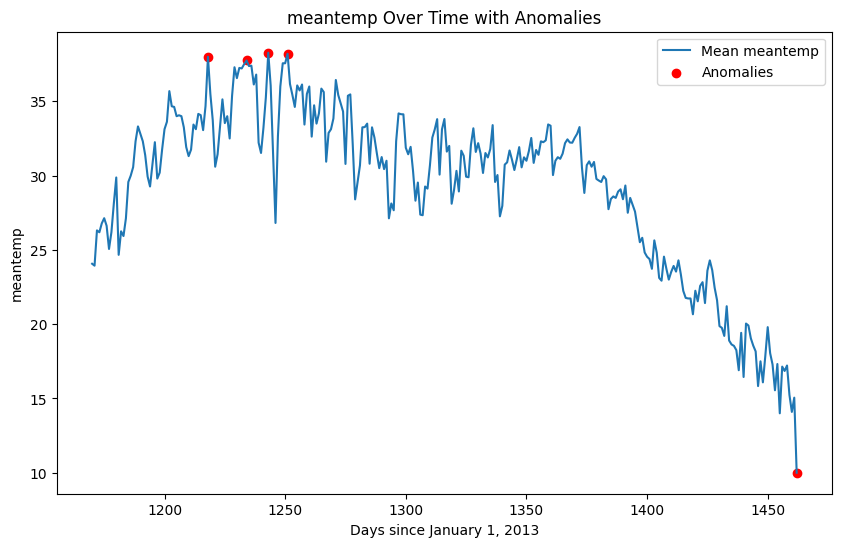

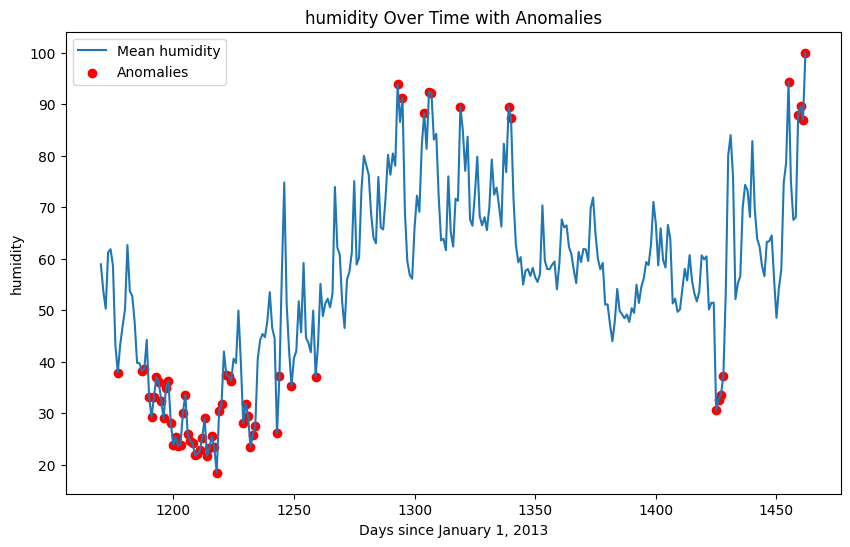

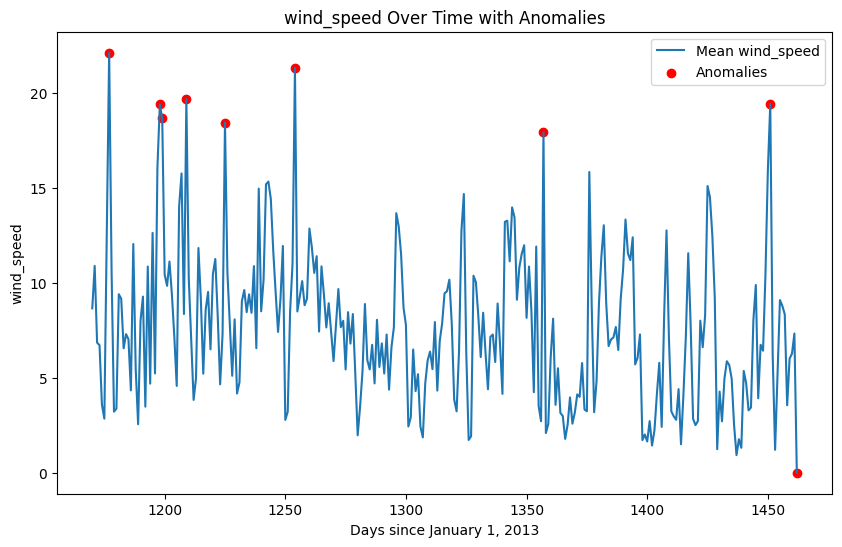

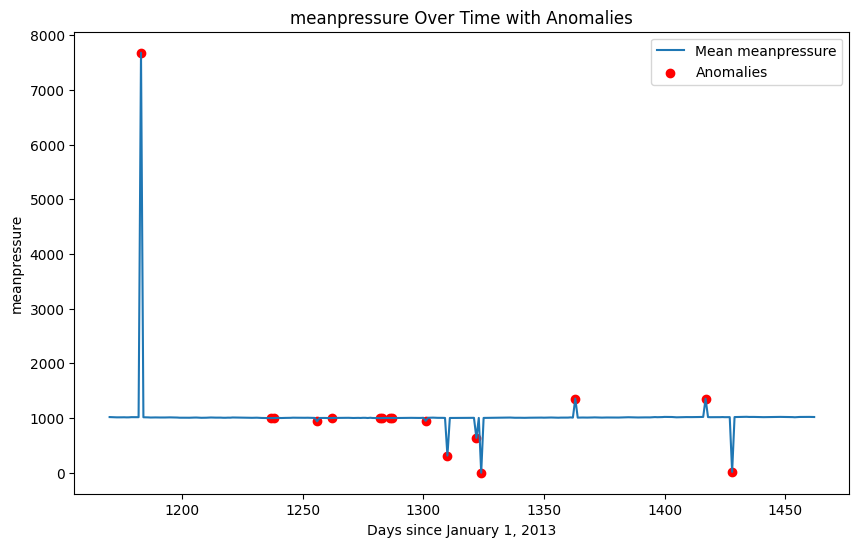

In [4]:
for col in df.columns[1:]:
    X = df[["date", col]]
    # subset the data
    prop = 0.8 * len(X)
    train = X[:int(prop)]
    test = X[int(prop):]

    # fit the model
    model = IsolationForest(n_estimators=100, max_samples= 200,
                            contamination=0.005, max_features= 1,
                            random_state=42)
    model.fit(train)
    anomalies = model.predict(test)

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(test["date"], test[col], label="Mean " + col)
    plt.scatter(test["date"][anomalies == -1],
                test[col][anomalies == -1],
                color='red', label="Anomalies")
    plt.xlabel("Days since January 1, 2013")
    plt.ylabel(col)
    plt.title(col + " Over Time with Anomalies")
    plt.legend()
    plt.show()

# Cloud Data Network Analysis

## Dataset Description

The dataset used for this project consists of real network traffic data from a single website server, available [here](https://www.kaggle.com/datasets/garystafford/ping-data). It contains the following:

- Ping measurements across several days

- Regular server requests

- Instances of extended high ping, indicating an attack or server overload

Specifically, the two variables that will be analyzed are in the table below.



| Variable   | Description                           |
|------------|---------------------------------------|
| timestamp  | Time of request                      |
| local_avg  | Average ping of all users at a given time |

## Methods

Two statistical and machine learning approaches are implemented to model the network traffic data and detect anomalies.

1. Prophet

  - Designed by Facebook for time-series forecasting
  - Captures trends, seasonality, and outliers
  - Good for data with regular patterns and occasional anomalies


2. ARIMA (Auto-Regressive Integrated Moving Average)

    - A classical time-series model
    - Models temporal tendencies
    - Good for detecting deviations in linear trends

## Results

The results for the implementation were done in Python on Google Colab, assuming that the dataset is on the user's google drive homepage.

Relevant graphics are generated, and interpretations are given after each graph.


#### Import all necessary libraries, and mount the user's drive if needed

In [5]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# Import data from google drive if applicable
# df = pd.read_csv("/content/drive/My Drive/ping_data.csv")

#### Data Preproccessing

Load in the data, isolate desired columns

In [8]:
# Read in data as dataframe
df = pd.read_csv('data/raw/ping_data.csv')

# Subset necessary columns
ping_data = df[['timestamp', 'local_avg']]

# Convert seconds to dates
ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'], unit='s')

# Subset data
ping_data = ping_data.iloc[:100]

<ipython-input-8-8e4c4bc5491c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'], unit='s')


#### Distribution of the dataset

The dataset can be visualized to get a better grasp of the relationship between time and ping.

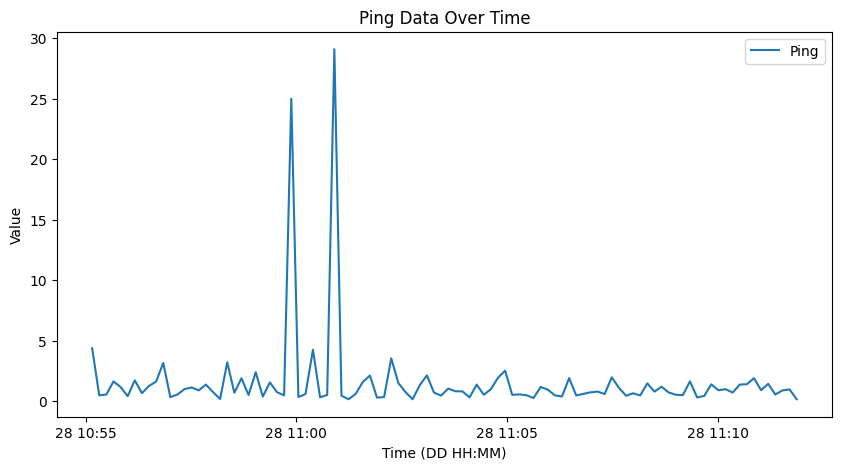

In [9]:
# Define X and Y variables for plotting
x = ping_data['timestamp']
y = ping_data['local_avg']

# Plot graph
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Ping')
plt.title('Ping Data Over Time')
plt.xlabel('Time (DD HH:MM)')
plt.ylabel('Value')
plt.legend()
plt.show()

From the graph, we see some clear abnormalities, potetially indicating high traffic volume.

Now, we can fit the time series models to the data.

### Prophet Model

In [10]:
# Split data into train and test
# 70% training (History), 30% test (To Forecast)
ping_data.rename(columns={'timestamp':'ds', 'local_avg': 'y'}, inplace=True)
train_size = int(0.7 * len(ping_data))
train = ping_data[:train_size]
test = ping_data[train_size:]

In [11]:
# Train Prophet model
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw87txuf/vwagcr44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw87txuf/hhhrd56y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37814', 'data', 'file=/tmp/tmpkw87txuf/vwagcr44.json', 'init=/tmp/tmpkw87txuf/hhhrd56y.json', 'output', 'file=/tmp/tmpkw87txuf/prophet_model4jss6_he/prophet_model-20241212222155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:21:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:55 - cmdstanpy - INFO - Chai

In [12]:
# Predict on training data
train_forecast = model.predict(train[['ds']])

# Combine relevant columns into training data for plotting
train['yhat'] = train_forecast['yhat']
train['residuals'] = train['y'] - train['yhat']

<ipython-input-12-f155e066a410>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat'] = train_forecast['yhat']
<ipython-input-12-f155e066a410>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = train['y'] - train['yhat']


In [14]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Combine anomaly predictions to training data, and flag anomalies
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

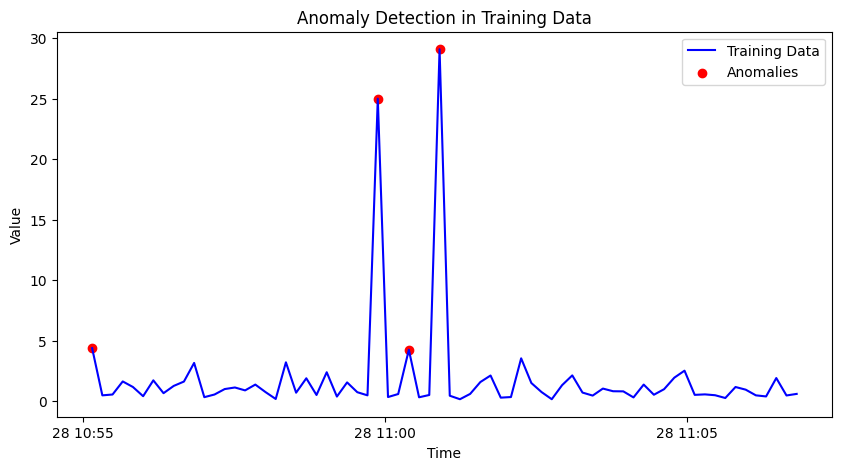

In [15]:
# Plot anomalies detected in training data
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

At a glance, the algorithm seems to be doing well. It detects the obvious anomalies, and it also detects anomalies that are slightly higher than the desired ping values.

In [16]:
# Predict on test data
test_forecast = model.predict(test[['ds']])

# Combine relevant columns into test data for plotting
test['yhat'] = test_forecast.loc[test_forecast['ds'].isin(test['ds']), 'yhat'].values
test['residuals'] = test['y'] - test['yhat']

In [18]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])

# Combine anomalies with test data and flag
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

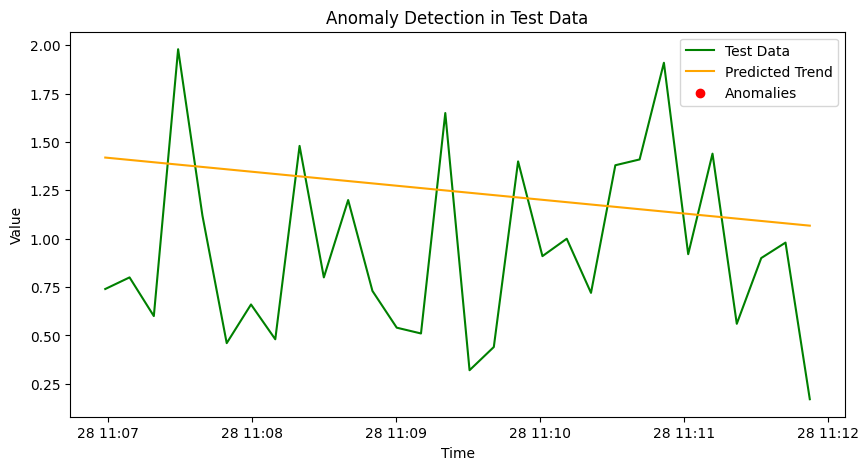

In [19]:
# Plot test anomaly detection, with predicted trend
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The model didn't detect any anomalies in the testing data, which is expected, as they are all relatively low, desired values. The trend was not predicted very precisely, but the average trend was predicted well, with a clear negative correlation.

Now, we can fit an ARIMA model to the data.

The parameters for ARIMA are Autoregressive Order (p), Differencing Order (d), and Moving Average (q). The best parameters were chosen after experimentation and simulation.

In [22]:
# Define the ARIMA model
model = ARIMA(train['y'], order=(5,1,0)) # (p, q d)
model_fit = model.fit()

In [23]:
# Predict on training data
train['yhat'] = model_fit.predict(start=0, end=len(train)-1, typ='levels')
train['residuals'] = train['y'] - train['yhat']

In [24]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

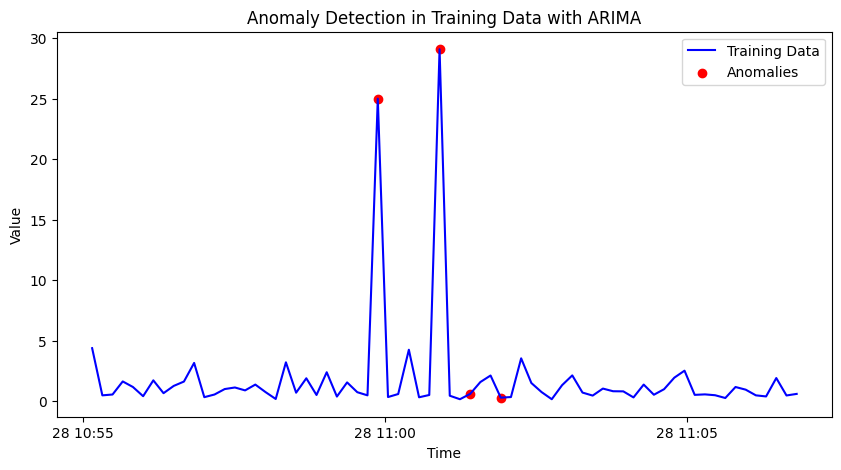

In [25]:
# Plot training anomalies
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

We see that the model classified the obvious anomalies well, but also classified some unexpected anomalies. This may be due to the proximity of the data points near the anomalies that is factored in to the ARIMA algorithm

In [26]:
# Predict on test data
test['yhat'] = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
test['residuals'] = test['y'] - test['yhat']

In [27]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

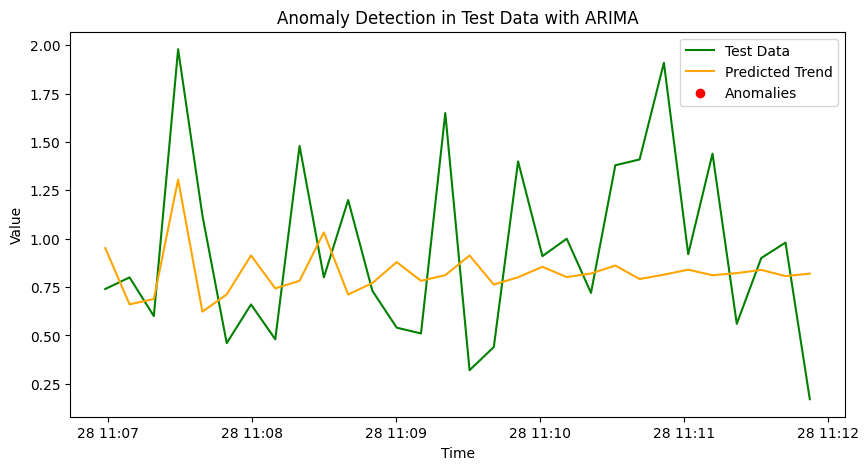

In [28]:
# Plot test anomalies
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The ARIMA also didn't detect any anomalies, which was the expected result, and the same as the Prophet model. However ARIMA did a better job at modeling and forecasting the trend. For Prophet, we saw that it predicted a linear trend, while for ARIMA, the predicted trend resembles the actual pattern of the predicted data.

## Conclusion

With more experimentation, a time series model like this could help detect issues with servers automatically in real time, allowing for efficient solution deployment.

